In [1212]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
import math

In [1213]:
# TRANSITIONS (Actions,States,States)
# REWARDS     (Actions,States,States)

Histories: $\mathcal{H} = [h_{-1}, h_{-2}, h_{-3}, h_{-4}]$. For the $(5,5)$ constraint, we only need to see that last four epoch's worth of withdrawals.

In [1214]:
# construct possible histories
all_combinations = itertools.product(range(6), repeat=4)
histories = np.asarray([combination for combination in all_combinations if sum(combination) <= 5])
histories[-1], len(histories)

(array([5, 0, 0, 0]), 126)

Pendings: $\mathcal{P} = [p_{1}, p_{10}]$. We only track the number of each value of withdrawals, where at most there are 20 pending at a time.

In [1215]:
# construct pendings
all_combinations = itertools.product(range(11), repeat=2)
pendings = np.asarray([combination for combination in all_combinations if sum(combination) <= 20])
pendings[-1], len(pendings)

(array([10, 10]), 121)

In [1216]:
len(histories), len(pendings)

(126, 121)

In [1217]:
# num states
len(pendings) * len(histories)

15246

In [1218]:
def tostr(arr):
    return ','.join(str(x) for x in arr)

Full state $\mathcal{S} = [\mathcal{P}, \mathcal{H}] = [p_{1}, p_{10}, h_{-1}, h_{-2}, h_{-3}, h_{-4}]$

In [1219]:
states = []
stateInds = {}
ind = 0
for i in tqdm(range(len(pendings))):
    for j in range(len(histories)):
        p, h = pendings[i], histories[j]
        full = np.concatenate((p,h))
        states.append(full)
        strrep = tostr(full)
        stateInds[strrep] = ind
        ind += 1
states = np.asarray(states)
len(stateInds), len(states)

100%|██████████| 121/121 [00:00<00:00, 680.78it/s]


(15246, 15246)

In [1220]:
# 6 actions -> total num of elements = 1.4bn, need to use sparsity
6*15246*15246

1394643096

In [1221]:
# reward for a state is the negative of the sum of the values.
def getReward(state):
    p1, p10 = state[0], state[1]
    return - (p1 + p10*10)

In [1222]:
states[12151], getReward(states[12151]) # reward is negative of new state

(array([8, 8, 0, 5, 0, 0]), -88)

Distribution for arrivals $X \sim [0, 1, 5] \; w.p. \; [0.5, 0.4, 0.1]$. 

Distribution of values $Y \sim [1, 10] \; w.p. \;  [0.9, 0.1]$.

In [1223]:
# all the values and probabilities for potential new pendings
numProbs = {0:0.5, 1:0.4, 5:0.1}
newPendings = [
    (0,0),
    (1,0),(0,1),
    (5,0),(4,1),(3,2),(2,3),(1,4),(0,5)]
newPendingProbs = [
    (0.9**ones)*(0.1**tens)*math.comb(ones+tens,ones)*numProbs[ones+tens]
    for (ones,tens) in newPendings]
newPendingProbs, sum(newPendingProbs)

([0.5,
  0.36000000000000004,
  0.04000000000000001,
  0.05904900000000001,
  0.032805,
  0.007290000000000002,
  0.0008100000000000004,
  4.500000000000001e-05,
  1.0000000000000004e-06],
 1.0)

demo transtitions from initial state

```
0 [0 0 0 0 0 0] [0 0 0 0 0 0] 0.5 0 0
1 [0 0 0 0 0 0] [1 0 0 0 0 0] 0.36000000000000004 1386 -1
2 [0 0 0 0 0 0] [0 1 0 0 0 0] 0.04000000000000001 126 -10
3 [0 0 0 0 0 0] [5 0 0 0 0 0] 0.05904900000000001 6930 -5
4 [0 0 0 0 0 0] [4 1 0 0 0 0] 0.032805 5670 -14
5 [0 0 0 0 0 0] [3 2 0 0 0 0] 0.007290000000000002 4410 -23
6 [0 0 0 0 0 0] [2 3 0 0 0 0] 0.0008100000000000004 3150 -32
7 [0 0 0 0 0 0] [1 4 0 0 0 0] 4.500000000000001e-05 1890 -41
8 [0 0 0 0 0 0] [0 5 0 0 0 0] 1.0000000000000004e-06 630 -50
```

In [1224]:
transitions = [lil_matrix((15246,15246), dtype=float) for _ in range(6)]
rewards = [lil_matrix((15246,15246), dtype=float) for _ in range(6)]
transitions[0].shape

(15246, 15246)

In [1225]:
# action = 0, do nothing, reward from newstate
for curInd, state in tqdm(enumerate(states)):
    for i, (ones, tens) in enumerate(newPendings):
        newState = np.copy(state)
        newState[0] += ones
        newState[1] += tens
        prob = newPendingProbs[i]
        
        # shift history
        newState[3:6] = newState[2:5]
        newState[2] = 0
        try:
            newInd = stateInds[tostr(newState)]
        except KeyError: # not a valid new state, leave state alone
            newInd = curInd
        transitions[0][curInd, newInd] += prob
        # rewards[0][curInd, newInd] = getReward(states[newInd])
        rewards[0][curInd, newInd] = getReward(states[curInd])

15246it [00:04, 3353.35it/s]


In [1226]:
# action = a, pop a (if possible), reward from newstate
for a in range(1,6):
    for curInd, state in tqdm(enumerate(states)):
        interState = np.copy(state)
        if sum(interState[2:]) + a > 5: # illegal action: violation of constraint
            transitions[a][curInd, curInd] += 1 # stay 
            rewards[a][curInd, curInd] = -10000 # big penalty
        elif sum(interState[:2]) < a:   # illegal action: not enough to process
            transitions[a][curInd, curInd] += 1 # stay
            rewards[a][curInd, curInd] = -10000 # big penalty
        else: # legal action: process
            p1, p10 = interState[0], interState[1]
            remTens = a - p10
            if remTens <= 0:  # only 10s consumed
                p10 -= a
            else:             # use the remainder to process 1s
                p10 = 0
                p1 -= remTens
            interState[0] = p1
            interState[1] = p10

            # shift history
            interState[3:6] = interState[2:5]
            interState[2] = a

            # new pendings
            for i, (ones, tens) in enumerate(newPendings):
                newState = np.copy(interState)
                # add new withdrawals
                newState[0] += ones
                newState[1] += tens
                prob = newPendingProbs[i]
                try:
                    newInd = stateInds[tostr(newState)]
                except KeyError: # not a valid new state, leave state alone
                    newInd = curInd
                transitions[a][curInd, newInd] += prob
                # rewards[a][curInd, newInd] = getReward(states[newInd])
                rewards[a][curInd, newInd] = getReward(states[curInd])

15246it [00:02, 5892.92it/s]
15246it [00:01, 10462.38it/s]
15246it [00:00, 20879.50it/s]
15246it [00:00, 33414.88it/s]
15246it [00:00, 43567.49it/s]


In [1227]:
transitions = np.asarray([
    csr_matrix(transitions[0]),
    csr_matrix(transitions[1]),
    csr_matrix(transitions[2]),
    csr_matrix(transitions[3]),
    csr_matrix(transitions[4]),
    csr_matrix(transitions[5]),
])
rewards = np.asarray([
    csr_matrix(rewards[0]),
    csr_matrix(rewards[1]),
    csr_matrix(rewards[2]),
    csr_matrix(rewards[3]),
    csr_matrix(rewards[4]),
    csr_matrix(rewards[5]),
])
transitions[1].shape

(15246, 15246)

In [1228]:
util.check(transitions, rewards)

In [1229]:
vi = mdp.ValueIteration(transitions, rewards, discount=0.9)
vi.run()
vi.iter

58

In [1230]:
vi.V[0], vi.policy[0]

(-27.09346516830788, 0)

In [1231]:
np.asarray(vi.policy).mean()

0.954873409418864

In [1232]:
opt_policy = np.asarray(vi.policy)
opt_policy.shape

(15246,)

Finding stationary distribution where $\pi = \pi T$ based on the transition matrix, $T$, calculated from the optimal policy.

In [1233]:
# stationary distribution
opt_transitions = lil_matrix((15246,15246), dtype=float)
opt_rewards = lil_matrix((15246,15246), dtype=float)
for i in range(15246):
    opt_transitions[i] = transitions[opt_policy[i]][i]
    opt_rewards[i] = rewards[opt_policy[i]][i]

In [1234]:
opt_transitions = csr_matrix(opt_transitions)
opt_rewards = csr_matrix(opt_rewards)

In [1235]:
util.check(np.asarray([opt_transitions]), np.asarray([opt_rewards]))

In [1236]:
opt_transitions.shape, opt_rewards.shape

((15246, 15246), (15246, 15246))

In [1317]:
opt_station = lil_matrix((1, 15246))
opt_station[0,0] = 1
iters = 0
while True:
    old = opt_station.copy()
    opt_station = opt_station.dot(opt_transitions)
    diff = np.abs(opt_station.toarray() - old.toarray())
    if diff.max() < float(1e-16):
        print(iters)
        break
    iters += 1

631


In [1318]:
opt_rewards.shape, opt_station.transpose().shape

((15246, 15246), (15246, 1))

Values of each state based on stationary are $v=R\pi^T$, based on reward matrix, $R$, calculated from the optimal policy.

In [1319]:
vals = opt_rewards.dot(opt_station.transpose())
vals.shape

(15246, 1)

Expected value of stationary distribution $eval = \pi v$.

So full flow is 

$eval = \pi (\frac{1}{1-\delta}R \pi^T).$

$eval = \pi (v \pi^T).$

In [1320]:
opt_station.dot(vals).toarray()

array([[-0.03979818]])

---- 
---
---

`PRIO-MINSLACK`

In [1321]:
# PRIO-MINSLACK
# stationary distribution
prio_transitions = lil_matrix((15246,15246), dtype=float)
prio_rewards = lil_matrix((15246,15246), dtype=float)
prio_policy = []
for i, state in enumerate(states):
    slack = 5 - sum(state[2:])
    avail = sum(state[:2])
    policy = 6
    if slack <= avail:
        policy = slack
    else: # avail > slack => can only do avail
        policy = avail
    prio_policy.append(policy)
    prio_transitions[i] = transitions[policy][i]
    prio_rewards[i] = rewards[policy][i]

In [1322]:
prio_transitions = csr_matrix(prio_transitions)
prio_rewards = csr_matrix(prio_rewards)
prio_policy = np.asarray(prio_policy)

In [1292]:
util.check(np.asarray([prio_transitions]), np.asarray([prio_rewards]))

In [1323]:
prio_transitions.shape, prio_rewards.shape

((15246, 15246), (15246, 15246))

In [1324]:
prio_station = lil_matrix((1, 15246))
prio_station[0,0] = 1
iters = 0
while True:
    old = prio_station.copy()
    prio_station = prio_station.dot(prio_transitions)
    diff = np.abs(prio_station.toarray() - old.toarray())
    if diff.max() < float(1e-16):
        print(iters)
        break
    iters += 1

694


In [1325]:
prio_rewards.shape, prio_station.transpose().shape

((15246, 15246), (15246, 1))

In [1326]:
vals = prio_rewards.dot(prio_station.transpose())
vals.shape

(15246, 1)

In [1327]:
prio_station.dot(vals).toarray()

array([[-0.01260002]])

In [1314]:
diffs = opt_station.toarray() - prio_station.toarray()
diffs.max(), diffs.argmax(), diffs.min(), diffs.argmin()

(0.011026312014151529, 8392, -0.001629968451525291, 1510)

In [1315]:
opt_station[0,1510], prio_station[0,1510]

(4.2837938155758777e-07, 0.0016303968309068486)

In [1316]:
states[1510], opt_policy[1510], prio_policy[1510]

(array([1, 0, 4, 1, 0, 0]), 0, 0)

---- 
---
---

`policy analysis`

In [1334]:
(np.argwhere(prio_policy - opt_policy > 1))

array([[ 9793],
       [11144],
       [11159],
       [11179],
       [11270],
       [12474],
       [12495],
       [12530],
       [12600],
       [13860]])

In [1335]:
ind = 13860
states[ind], prio_policy[ind], opt_policy[ind]

(array([10,  0,  0,  0,  0,  0]), 5, 3)

---- 
---
---

`simulations`

In [1714]:
# sims
def sim_both(n=None):
    prio_state = np.array([0, 0, 0, 0, 0, 0])
    opti_state = np.array([0, 0, 0, 0, 0, 0])
    prio_rewards, opti_rewards = [], []
    for curTime in tqdm(range(n)):
        if curTime > 1000:
            # add rewards for existing state
            prio_rewards.append(getReward(prio_state))
            opti_rewards.append(getReward(opti_state))
        
        # get actions
        try:
            prioStateInd = stateInds[tostr(prio_state)]
            prio_action = prio_policy[prioStateInd] 
        except KeyError:
            # just use all capacity if we are getting long.
            slack = 5 - sum(prio_state[2:])
            prio_action = slack
        try:
            optiStateInd = stateInds[tostr(opti_state)]
            opti_action = opt_policy[optiStateInd]
        except KeyError:
            # just use all capacity if we are getting long.
            slack = 5 - sum(opti_state[2:])
            opti_action = slack

        # process withdrawals
        p1, p10 = prio_state[0], prio_state[1]
        remTens = prio_action - p10
        if remTens <= 0:  # only 10s consumed
            p10 -= prio_action
        else:             # use the remainder to process 1s
            p10 = 0
            p1 -= remTens
        prio_state[0] = p1
        prio_state[1] = p10
        
        p1, p10 = opti_state[0], opti_state[1]
        remTens = opti_action - p10
        if remTens <= 0:  # only 10s consumed
            p10 -= opti_action
        else:             # use the remainder to process 1s
            p10 = 0
            p1 -= remTens
        opti_state[0] = p1
        opti_state[1] = p10
        
        # shift history
        prio_state[3:6] = prio_state[2:5]
        prio_state[2] = prio_action
        opti_state[3:6] = opti_state[2:5]
        opti_state[2] = opti_action

        # Add new pendings
        numWdraws = np.random.choice([0,1,5], p=[0.5, 0.4, 0.1])
        newValues = np.random.choice([1, 10], p=[0.9, 0.1], size=numWdraws)
        prio_state[0] += np.count_nonzero(newValues == 1)
        prio_state[1] += np.count_nonzero(newValues == 10)
        opti_state[0] += np.count_nonzero(newValues == 1)
        opti_state[1] += np.count_nonzero(newValues == 10)

    prio_rewards = np.asarray(prio_rewards)
    opti_rewards = np.asarray(opti_rewards)
    return prio_rewards, opti_rewards

In [1715]:
prio_r, opti_r = sim_both(n=50000)

100%|██████████| 50000/50000 [00:05<00:00, 9639.37it/s] 


In [1716]:
prio_r, opti_r

(array([ -1,  -1,  -1, ..., -22, -23, -23]),
 array([ -1,  -1,  -1, ..., -23, -23, -23]))

In [1717]:
prio_r.mean(), opti_r.mean()

(-11.323924978060777, -11.357905263372722)

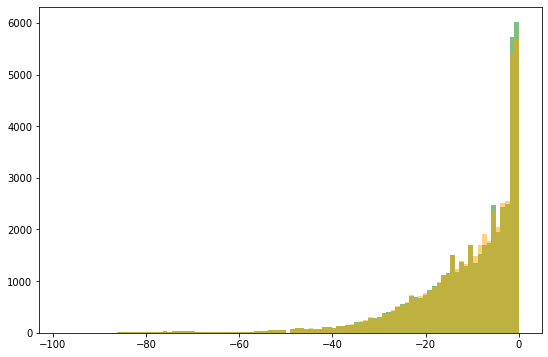

In [1723]:
f, ax = plt.subplots(figsize=(9,6))
ax.hist(prio_r, bins=100, color='green', alpha=0.5)
ax.hist(opti_r, bins=100, color='orange', alpha=0.5)

plt.show()

In [1008]:
# policy
[round(i) for i in np.array([0,1,2,3,4,5]) * 0.9]

[0, 1, 2, 3, 4, 4]

In [1000]:
[0, 1, 1, 3, 4, 5]

[0, 1, 1, 3, 4, 5]

In [891]:
# alpha-MINSLACK
# stationary distribution
opt_transitions = lil_matrix((15246,15246), dtype=float)
opt_rewards = lil_matrix((15246,15246), dtype=float)
for i, state in enumerate(states):
    slack = 5 - sum(state[2:])
    # alpha=0.85
    if slack > 3:
        slack -= 1
    avail = sum(state[:2])
    policy = 6
    if slack <= avail:
        policy = slack
    else: # avail > slack => can only do avail
        policy = avail
    opt_transitions[i] = transitions[policy][i]
    opt_rewards[i] = rewards[policy][i]

In [892]:
opt_transitions = csr_matrix(opt_transitions)
opt_rewards = csr_matrix(opt_rewards)

In [893]:
util.check(np.asarray([opt_transitions]), np.asarray([opt_rewards]))

In [894]:
opt_transitions.shape, opt_rewards.shape

((15246, 15246), (15246, 15246))

In [895]:
curr = lil_matrix((1, 15246))
curr[0,0] = 1
iters = 0
while True:
    old = curr.copy()
    curr = curr.dot(opt_transitions)
    diff = np.abs(curr.toarray() - old.toarray())
    if diff.max() < 0.0001:
        print(iters)
        break
    iters += 1

417


In [896]:
opt_rewards.shape, curr.transpose().shape

((15246, 15246), (15246, 1))

In [897]:
vals = opt_rewards.dot(curr.transpose())
vals.shape

(15246, 1)

In [899]:
curr.dot(vals).toarray()

array([[-2.83564301]])

In [600]:
curr.shape, opt_transitions[0].transpose().shape

((1, 15246), (15246, 1))

In [557]:
curr = lil_matrix((1, 15246))
curr[0,0] = 1
curr

csr_matrix.multipy(curr, )

<1x15246 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in List of Lists format>

In [561]:
curr = np.zeros((1, 2))
curr[0][0] = 1

trans = np.zeros((2,2))
trans[0,0] = 0.3
trans[0,1] = 0.7
trans[1,0] = 0.5
trans[1,1] = 0.5

curr = np.matmul(curr, trans)
curr

array([[0.3, 0.7]])

In [595]:
curr = lil_matrix((1, 2))
curr[0,0] = 1
curr.toarray()

array([[1., 0.]])

In [601]:
curr = lil_matrix((1, 2))
curr[0,0] = 1

trans = lil_matrix((2,2))
trans[0,0] = 0.3
trans[0,1] = 0.7
trans[1,0] = 0.5
trans[1,1] = 0.5

curr = curr.dot(trans)
curr.toarray()

array([[0.3, 0.7]])

In [615]:
curr = curr.dot(trans)
curr.toarray()

array([[0.41666667, 0.58333333]])

In [616]:
opt_transtitions

NameError: name 'opt_transtitions' is not defined

In [547]:
opt_transitions.transpose()[:,0].sum()

1.0

In [553]:
curr = lil_matrix((1, 15246))
curr[0][0] = 1

out = opt_transitions.multiply(opt_transitions)

0.25

In [494]:
curr = np.zeros(15246)
curr[0] = 1 
iters = 0
while True:
    old = np.copy(curr)
    curr = opt_transitions.dot(curr)
    diff = np.abs(curr - old)
    if diff.max() < 0.0001:
        print(iters)
        break
    iters += 1

13


In [502]:
curr.sum()

6.103515625e-05

In [447]:
for i in range(15246):
    pr = transitions[1][i].sum()
    if pr < 0.99 or pr > 1.01:
        print(i)
        break

0


In [448]:
transitions[1][0].sum(), transitions[1][0].indices

(5.0, array([0], dtype=int32))

In [425]:
states[126], states[686]

(array([0, 1, 0, 0, 0, 0]), array([0, 5, 1, 0, 0, 0]))

In [433]:
curInd = 126
state = states[curInd]
interState = np.copy(state)
reward = 0
if sum(interState[2:]) + 1 > 5: # illegal action: violation of constraint
    print("bad")
elif sum(interState[:2]) < 1:   # illegal action: not enough to process
    print("bad")
else: # legal action: process
    print("good")
    p1, p10 = interState[0], interState[1]
    remTens = 1 - p10
    if remTens <= 0:  # only 10s consumed
        p10 -= 1
    else:             # use the remainder to process 1s
        p10 = 0
        p1 -= remTens
    interState[0] = p1
    interState[1] = p10
    print(state)

    interState[3:6] = interState[2:5]
    interState[2] = 1
    print(interState)
    for i, (ones, tens) in enumerate(newPendings):
        newState = np.copy(interState)
        # add new withdrawals
        newState[0] += ones
        newState[1] += tens
        prob = newPendingProbs[i]
        try:
            newInd = stateInds[tostr(newState)]
        except KeyError: # not a valid new state, leave state alone
            newInd = curInd
        print(newState, prob, curInd, newInd)
#     transitions[1][curInd, newInd] += prob
#     rewards[1][curInd, newInd] = getReward(states[newInd])

good
[0 1 0 0 0 0]
[0 0 1 0 0 0]
[0 0 1 0 0 0] 0.5 126 56
[1 0 1 0 0 0] 0.36000000000000004 126 1442
[0 1 1 0 0 0] 0.04000000000000001 126 182
[5 0 1 0 0 0] 0.05904900000000001 126 6986
[4 1 1 0 0 0] 0.032805 126 5726
[3 2 1 0 0 0] 0.007290000000000002 126 4466
[2 3 1 0 0 0] 0.0008100000000000004 126 3206
[1 4 1 0 0 0] 4.500000000000001e-05 126 1946
[0 5 1 0 0 0] 1.0000000000000004e-06 126 686


In [401]:
util.check(transitions, rewards)

StochasticError: 'PyMDPToolbox - The transition probability matrix is not stochastic.'

In [3]:
mdp.ValueIteration()

TypeError: __init__() missing 3 required positional arguments: 'transitions', 'reward', and 'discount'

In [1132]:
test = np.array([1, 2, 0, 0, 0, 5])
print(test)
test[3:6] = test[2:5]
test[2] = 0
print(test)

[1 2 0 0 0 5]
[1 2 0 0 0 0]


In [1128]:
transitions[0][stateInds['1,2,0,0,0,5'],stateInds['1,2,0,0,0,5']]

0.5

In [1127]:
state = '1,2,0,0,0,5'
stateInd = stateInds[state]
action = 0
inds = transitions[action][stateInd].indices
for ind in inds:
    print(ind, states[ind], rewards[action][stateInd,ind], transitions[action][stateInd,ind])

1643 [1 2 0 0 0 5] -21.0 0.5
1769 [1 3 0 0 0 5] -21.0 0.04000000000000001
2273 [1 7 0 0 0 5] -21.0 1.0000000000000004e-06
3029 [2 2 0 0 0 5] -21.0 0.36000000000000004
3533 [2 6 0 0 0 5] -21.0 4.500000000000001e-05
4793 [3 5 0 0 0 5] -21.0 0.0008100000000000004
6053 [4 4 0 0 0 5] -21.0 0.007290000000000002
7313 [5 3 0 0 0 5] -21.0 0.032805
8573 [6 2 0 0 0 5] -21.0 0.05904900000000001


In [1276]:
vals1 = opt_station.dot(opt_rewards)
vals1.shape

(1, 15246)

In [1277]:
vals2 = opt_rewards.dot(opt_station.transpose())
vals2.shape

(15246, 1)

In [1278]:
(vals1.toarray().flatten() - vals2.toarray().flatten()).mean()

0.0016412298622359217

In [1279]:
vals1.dot(opt_station.transpose()).toarray(), vals2.transpose().dot(opt_station.transpose()).toarray()

(array([[-0.03590152]]), array([[-0.03590152]]))

In [1280]:
opt_station.dot(vals1.transpose()).toarray(), opt_station.dot(vals2).toarray()

(array([[-0.03590152]]), array([[-0.03590152]]))